# Euclidean latent space model for Networks: Model $\mathbb{R}^3$

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from Modules.EuclideanM import *
from Modules.EuclideanV import *
from Modules.EuclideanC import *

## Network

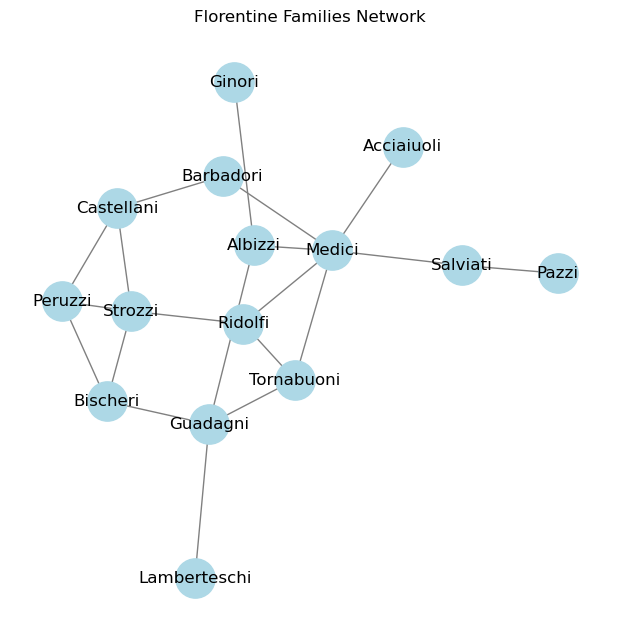

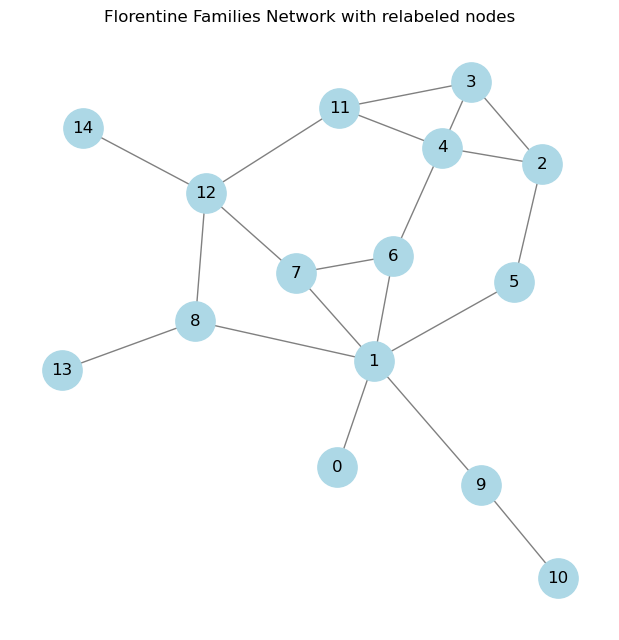

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


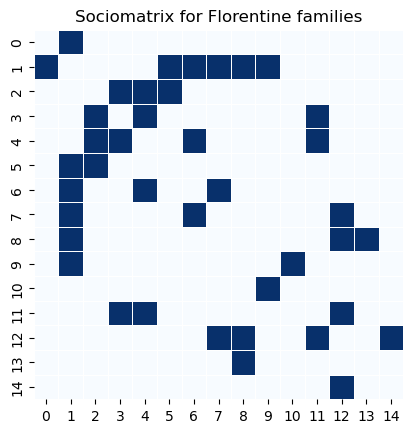

In [2]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()

G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)
n = len(G.nodes)
plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix for Florentine families")
plt.show()

## Latent space

### Frequentist inference

Initial log-likelihood: -162.17769380361688
Final log-likelihood: -0.20732574137639467
Final alpha: 17.160249545669373


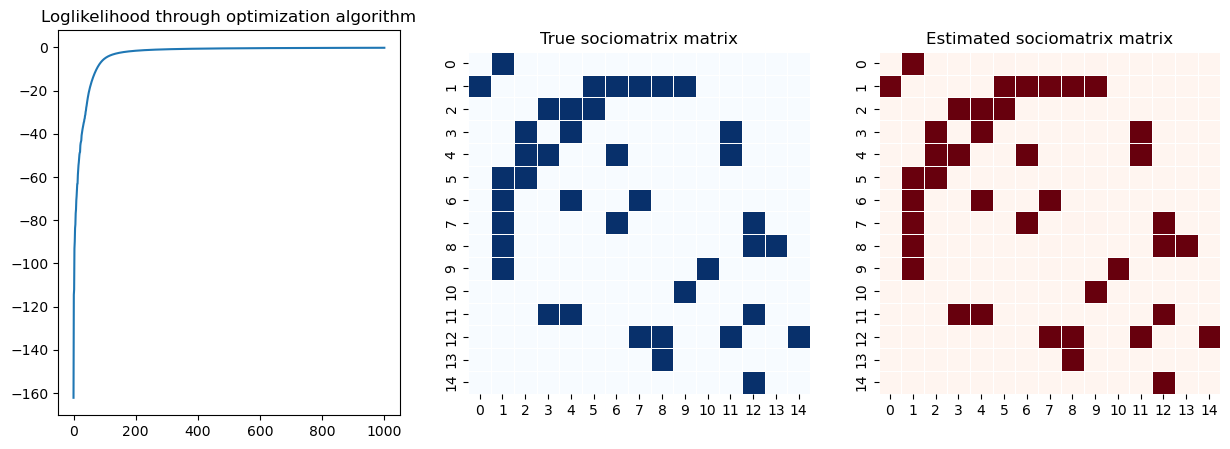

In [3]:

Z_init = np.random.randn(n, 3)
a_init = np.random.randn()

Z_ML, a_ML, historyZ, historya =  SearchingMLE(G, Z_init ,a_init,1000)
print("Initial log-likelihood:", loglikelihood(G,Z_init,a_init))
print("Final log-likelihood:", loglikelihood(G,Z_ML,a_ML))
print("Final alpha:", a_ML)
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_ML[i,j] = expit(a_ML - 0.5 * np.linalg.norm(Z_ML[i] - Z_ML[j])**2)


df = pd.DataFrame(Z_ML, columns=['x', 'y', 'z'])
df['node'] = list(G.nodes)
fig = px.scatter_3d(df, x='x', y='y', z='z', text='node', opacity=0.9)
fig.update_layout(title='Maximum likelihood estimation of latent positions')
fig.show()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot([loglikelihood(G, historyZ[t],historya[t]) for t in range(len(historya))])
plt.title("Loglikelihood through optimization algorithm")
plt.subplot(1,3,2)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,3,3)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

### Bayesian inference

In [4]:
# Execute HMC
number_of_samples = 25000
Z_init = Z_init
a_init = np.float64(a_init)

print("Log-L MLE:", loglikelihood(G,Z_ML,a_ML))
print("Log-L starter:", loglikelihood(G,Z_init,a_init))

samples_Z, samples_a, Hp, LogLp, acep_rate_history = hmc(G, Z_init, a_init, number_of_samples, 
                                                         epsilon_init=0.02, std_dev_Z=0.25,  std_dev_a=1.0,
                                                         percentage_warmup=0.0, Z0 = Z_ML)

# Estimators
## CM
Z_CM =  np.mean(samples_Z, axis=0)
a_CM = np.mean(samples_a, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]


print("Log-L MAP:", loglikelihood(G,Z_MAP,a_MAP))
print("Log-L CM:", loglikelihood(G,Z_CM,a_CM))

Log-L MLE: -0.20732574137639467
Log-L starter: -162.17769380361688
Number of samples: 25000
Number of parameters: 16
Number of iterations: 25000
Number of warmup iterations: 0


  0%|          | 0/25000 [00:00<?, ?it/s]

Final parameters: epsilon=0.0200, L=50, std_dev_Z=0.2500, std_dev_a=1.0000


100%|██████████| 25000/25000 [4:43:37<00:00,  1.47it/s]  


Acceptance rate: 0.67064
Log-L MAP: -46.57001882840233
Log-L CM: -39.160177124559716


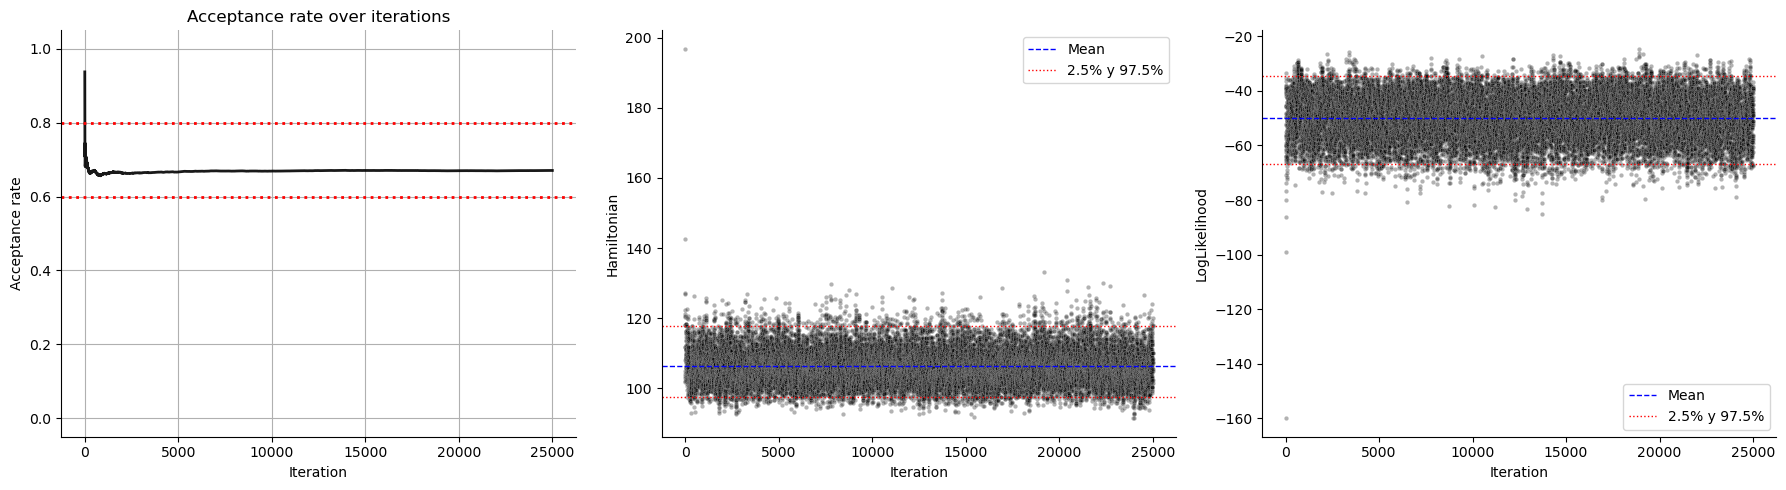

In [5]:
plot_diagnostics(Hp,LogLp,acep_rate_history)

In [6]:
plot_Z_samples_3D(samples_Z[-500:])

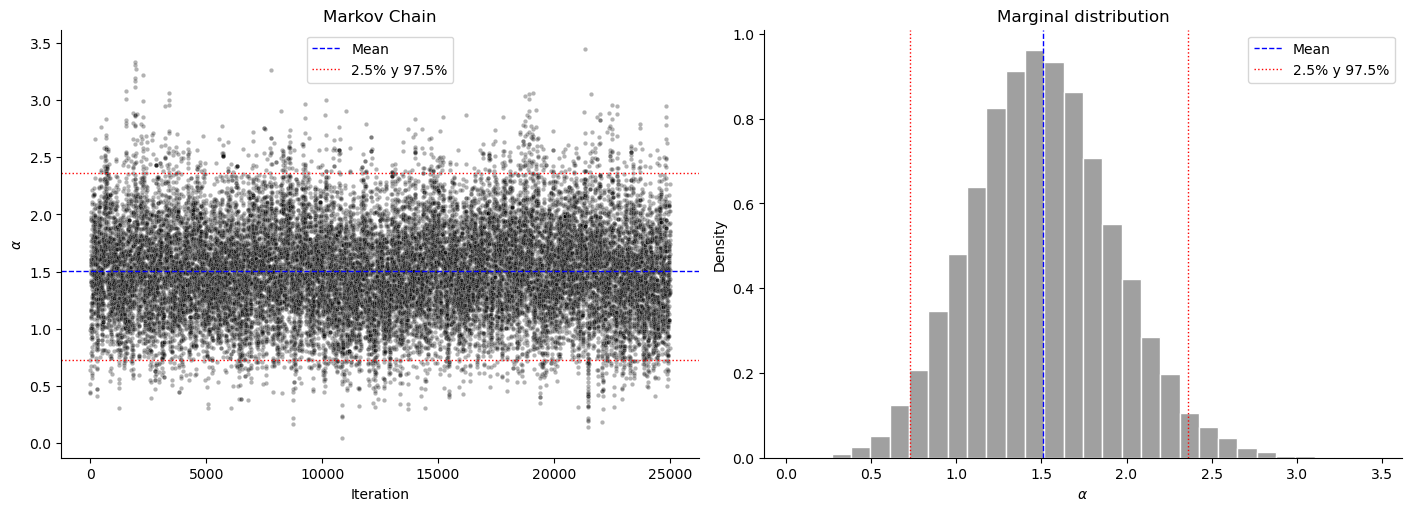

In [7]:
plot_alpha(samples_a)

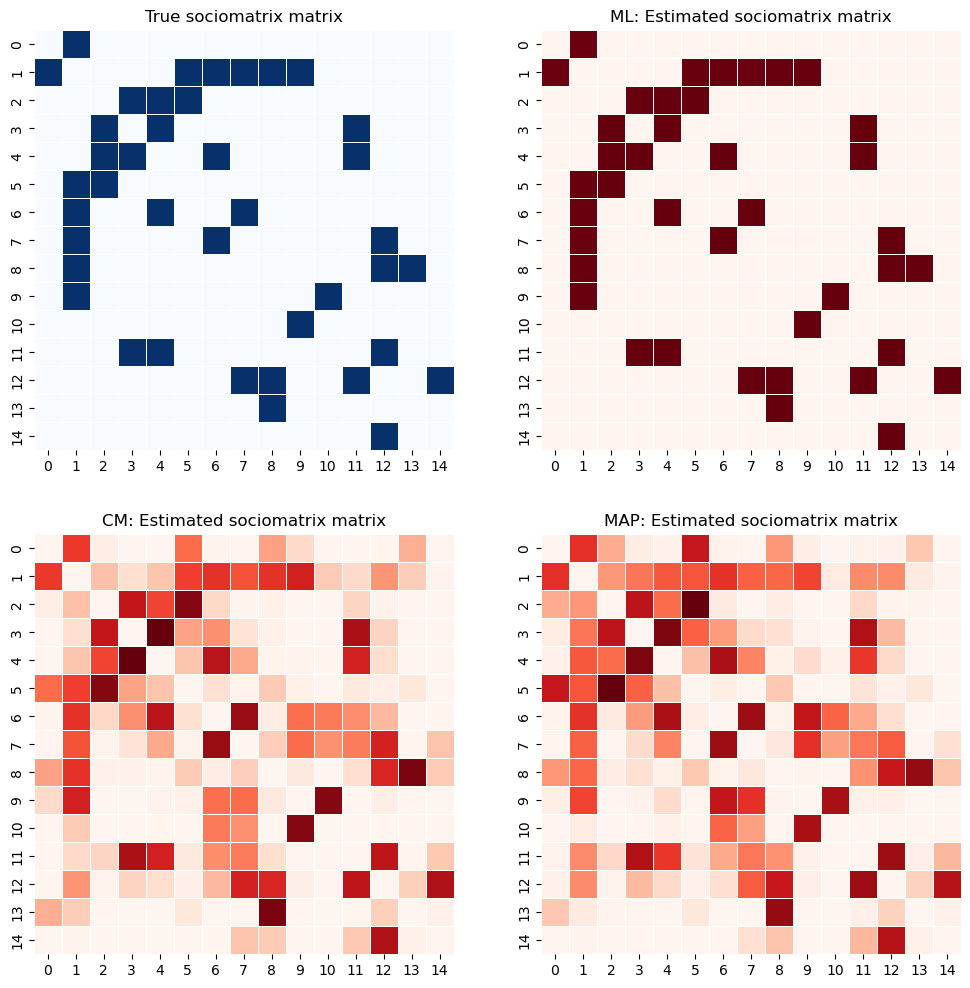

In [8]:
Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_CM[i,j] = expit(a_CM - 0.5 * np.linalg.norm(Z_CM[i] - Z_CM[j])**2)

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_MAP[i,j] = expit(a_MAP - 0.5 * np.linalg.norm(Z_MAP[i] - Z_MAP[j])**2)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

In [9]:
clustering3D(G,node_mapping, Z_ML, a_ML, Z_MAP, a_MAP, Z_CM, a_CM)

[[6, 7], [8, 13], [3, 4, 11], [9, 10], [12, 14], [0, 1], [2, 5]]

### Model Evaluation

#### Posterior predictive checking

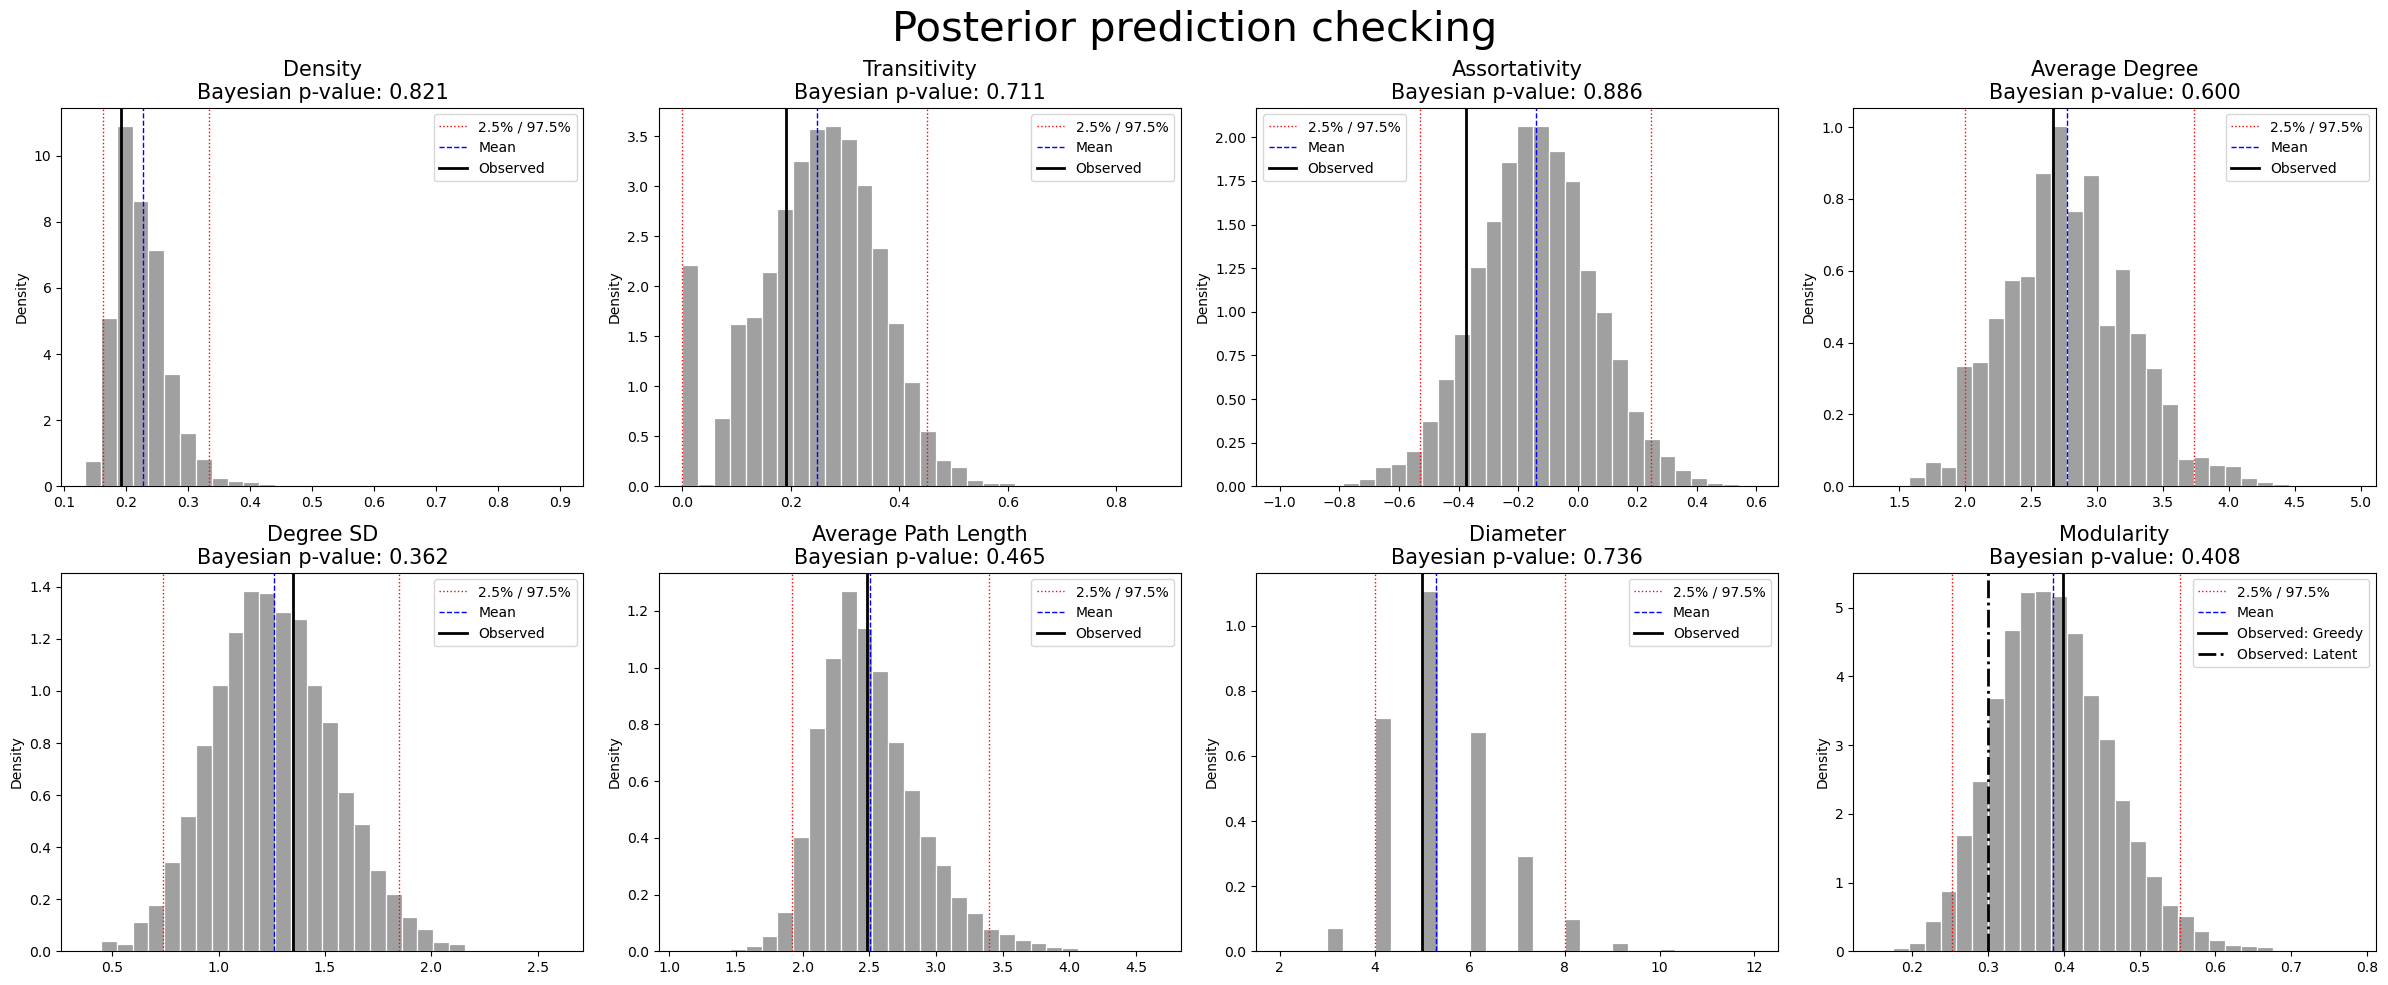

In [10]:
predictive_check(G,samples_Z,samples_a)

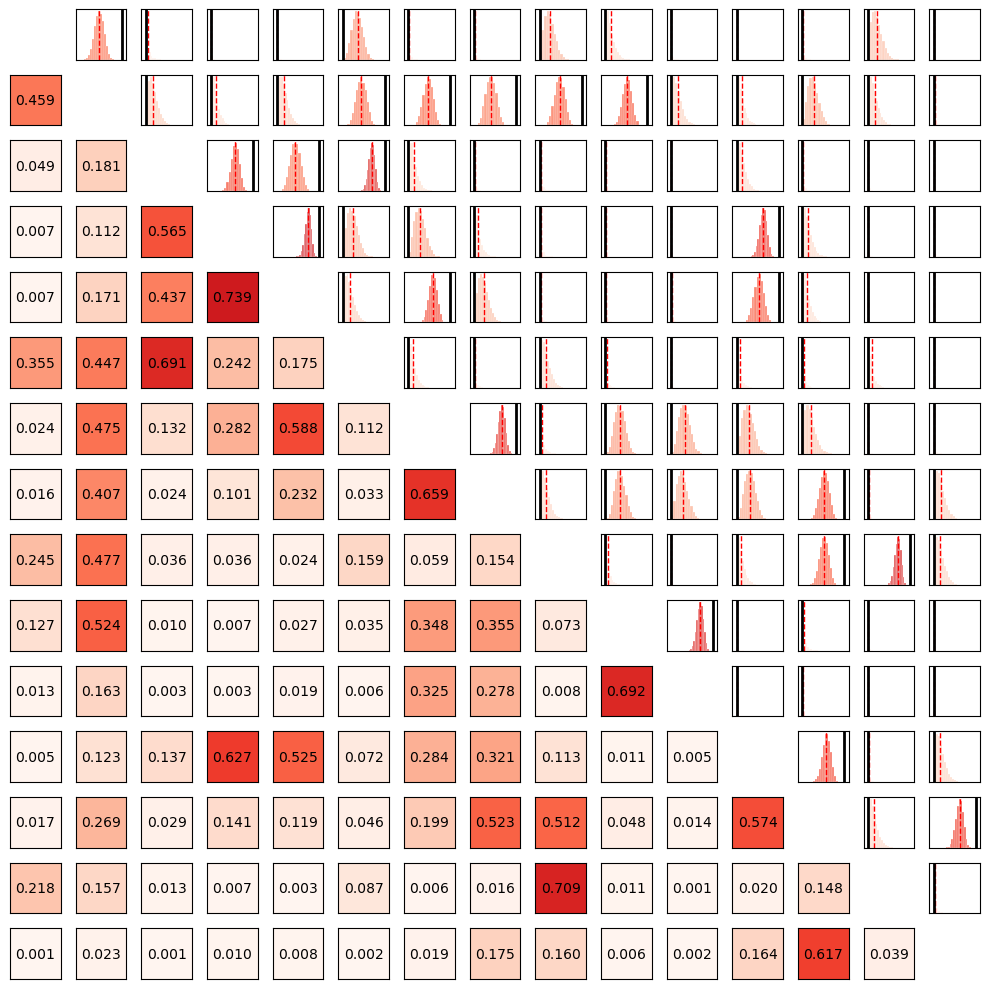

In [11]:
plot_pairwise_sociomatrix(G,samples_Z,samples_a,Y)

#### Model comparison criteria

In [12]:
log_lik = compute_log_likelihood(Y, samples_Z, samples_a)
waic = compute_WAIC(log_lik)
dic = compute_DIC(log_lik, Y, samples_Z, samples_a)


print(f"WAIC: {waic:.4f}")
print(f"DIC: {dic:.4f}")

WAIC: 90.4474
DIC: 95.0145


#### Prior predictive checking

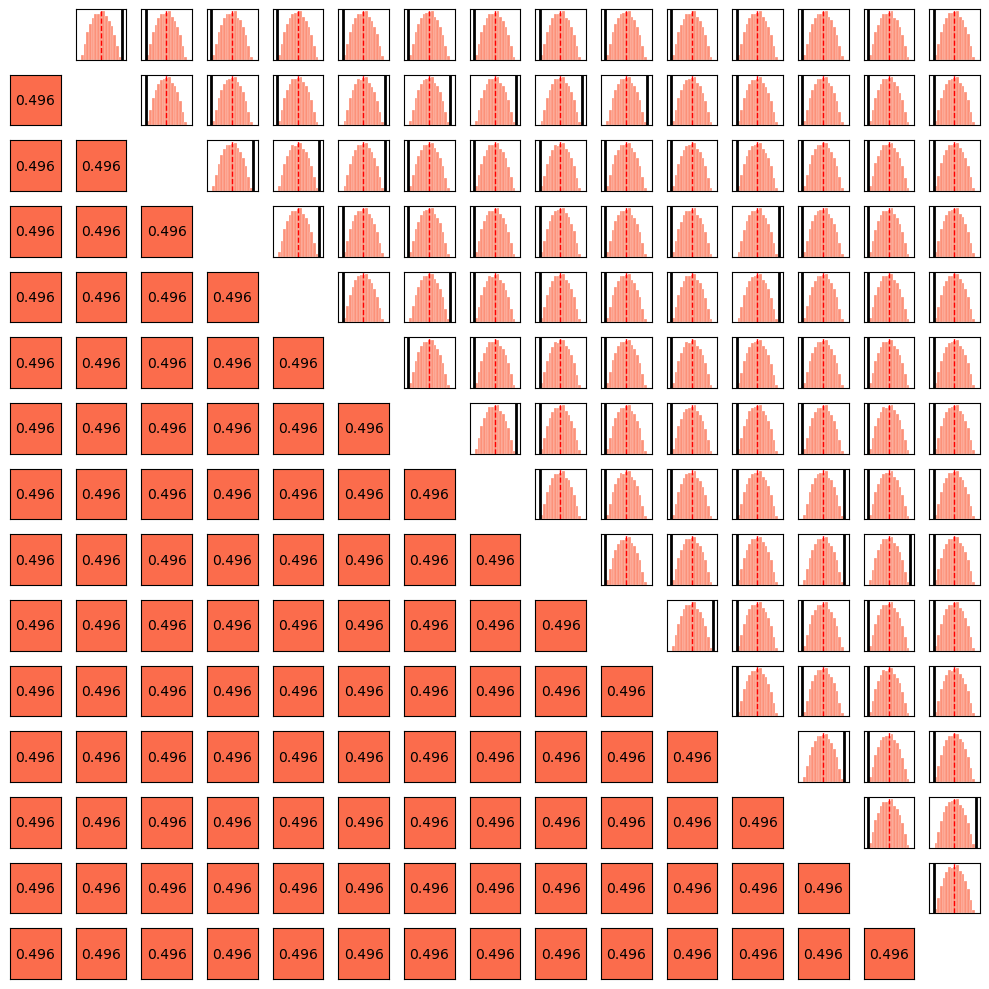

In [13]:
samples_Z_prior = 0.1*np.random.randn(number_of_samples, n, 2)
samples_a_prior = np.random.randn(number_of_samples)
plot_pairwise_sociomatrix(G,samples_Z_prior,samples_a_prior,Y)

#### Prediction evaluation

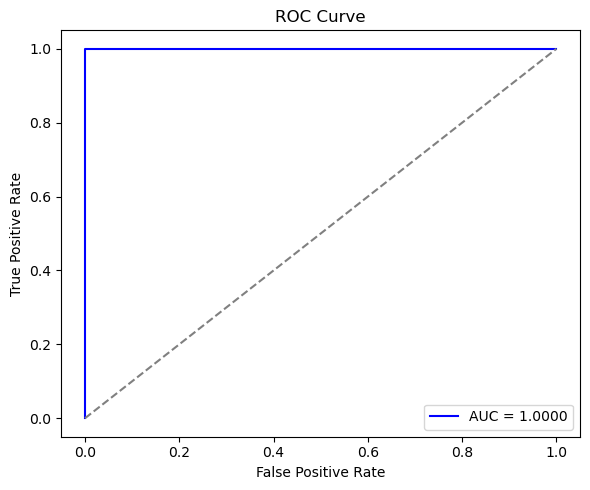

{'roc_auc': 1.0,
 'confusion_matrix': {'tp': 14, 'tn': 85, 'fp': 0, 'fn': 6},
 'accuracy': 0.9428571428571428,
 'precision': 1.0,
 'recall': 0.7,
 'f1_score': 0.8235294117647058,
 'specificity': 1.0}

In [14]:
roc_analysis(Y, posterior_connection_probs(samples_Z, samples_a))

In [15]:
saving_results((samples_Z, samples_a), Hp, LogLp, acep_rate_history, filename="FlorentineR3.xlsx")

Saving samples...
Saving diagnostics...
Results saved to FlorentineR3.xlsx


## References

[1]